### import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle
from shapeGMMTorch import similarities 
from shapeGMMTorch import plots

### load trajectory

In [2]:
data_path = "../iter-1/run_opes_metad_sim/analysis/"
backbone_selection_101 = "(name C and resid 1) or (name C CA N and not resid 1 35) or (name N and resid 35)"
prmtopFileName =  data_path + "npt_prot_only.gro"
trajFile = data_path+"opes_ld1_hp35_360K_bf_8_barrier_10_wrapped.xtc"

coord = md.Universe(prmtopFileName,trajFile)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)
traj_backbone_101 = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0
for ts in coord.trajectory:
    traj_backbone_101[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

Number of atoms in trajectory: 577
Number of frames in trajectory: 300001
Number of atoms being analyzed: 101
Number of frames being analyzed: 300001


In [3]:
print(traj_backbone_101.shape)
traj = traj_backbone_101[::3]
print(traj.shape)

(300001, 101, 3)
(100001, 101, 3)


### load OPES bisas from COLVAR

(100001,)
(100001,)


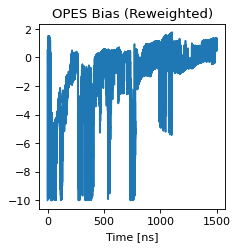

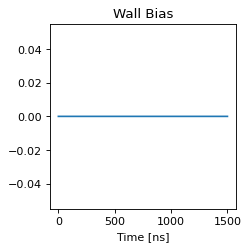

In [4]:
time, ld1, opes_bias = np.loadtxt(data_path+"../COLVAR", usecols=(0,1,2), unpack=True)
time *= 1e-3 # in ns 

wall_bias = np.sum(np.loadtxt(data_path+"../COLVAR", usecols=(-2,-1)), axis=1)[::15]
print(wall_bias.shape)

opes_bias = opes_bias[::15]
time = time[::15]
ld1 = ld1[::15]
print(opes_bias.shape)

plt.figure(figsize=(3,3), dpi=80)
plt.xlabel("Time [ns]")
plt.title("OPES Bias (Reweighted)")
plt.plot(time, opes_bias)

plt.figure(figsize=(3,3), dpi=80)
plt.xlabel("Time [ns]")
plt.title("Wall Bias")
plt.plot(time, wall_bias)

### get the weights

Here all the frames have zero wall bias, so we don't need to worry about ignoring the frames with non zero wall bias.

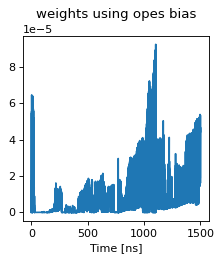

In [5]:
#When the temperature is 360.000000 kelvin kT is equal to 0.715393 kcal/mol
kt = 0.715393
weights = np.exp(opes_bias/kt)
weights /= np.sum(weights)

plt.figure(figsize=(3,3), dpi=80)
plt.xlabel("Time [ns]")
plt.title("weights using opes bias")
plt.plot(time, weights)

### perform cluster scan 

In [6]:
# define cluster array
cluster_array = np.arange(2,8,1).astype(int)
print(cluster_array)

[2 3 4 5 6 7]


In [7]:
print(traj.shape, weights.shape)

(100001, 101, 3) (100001,)


In [25]:
# perform cluster scan on this data (use ~ 90% data for training)
#train, cv = scripts.cross_validate_cluster_scan(traj, 90000, frame_weights = weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 10, dtype=torch.float64, device=torch.device("cuda:0"))

# write to data files
#np.savetxt("train.dat", np.column_stack((cluster_array, train)))
#np.savetxt("cv.dat", np.column_stack((cluster_array, cv)))

Number of frames to train each model: 90000
Number of frames to predict each model: 10001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               2               1             371.181          16.971
              1               2               2             372.259          24.114
              1               2               3             371.659          22.892
              1               2               4             371.741          27.803
              1               2               5             371.659          25.806
              1               2               6             371.607          29.840
              1               2               7             371.741          29.981
              1               2               8             371.7

              2               5               5             390.681          30.779
              2               5               6             383.763          35.906
              2               5               7             393.635          32.652
              2               5               8             389.733          81.662
              2               5               9             398.909          33.561
              2               5              10             390.494          37.331
              2               6               1             400.951          44.722
              2               6               2             395.796          30.053
              2               6               3             402.227          56.601
              2               6               4             400.269          30.323
              2               6               5             393.469          42.989
              2               6               6             400.867         

In [8]:
train = np.loadtxt("train.dat")[:,1:]
cv = np.loadtxt("cv.dat")[:,1:]

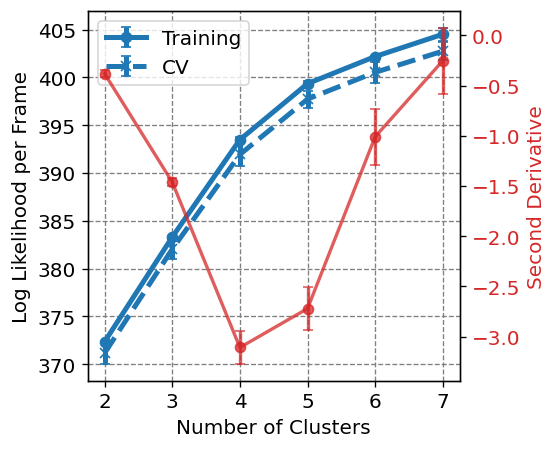

In [9]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi= 120, facecolor='w', edgecolor='k')
plots.plot_log_likelihood_with_dd(ax,cluster_array, train, cv, fontsize=12, ylabel1=True, ylabel2=True, xlabel=True)

### 3 clusters

In [27]:
#wsgmm3 = scripts.sgmm_fit_with_attempts(traj, 3, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

#with open("wsgmm_3states.pickle", "wb") as f_o:
#    pickle.dump(wsgmm3, f_o)

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1             379.087          29.220
       2             379.264          30.021
       3             383.226          36.203
       4             378.861          31.851
       5             378.859          27.999
       6             382.919          30.623
       7             383.216          37.838
       8             379.163          29.574
       9             378.814          28.609
      10             379.166          23.741
      11             378.794          29.794
      12             378.958          31.256
      13             378.794          39.506
      14             379.175          35.033
      15             377.711          31.160
      16             378.885          30.318
      17             378.737          32.484
      18             382.270          68.820
      19       

### 4 clusters 

In [28]:
#wsgmm4 = scripts.sgmm_fit_with_attempts(traj, 4, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

#with open("wsgmm_4states.pickle", "wb") as f_o:
#    pickle.dump(wsgmm4, f_o)

Number of training frames: 100001
Number of clusters: 4
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1             386.936          31.614
       2             381.228          40.642
       3             387.578          36.071
       4             387.508          35.301
       5             387.497          33.465
       6             380.246          55.403
       7             385.364          52.445
       8             387.929          43.770
       9             388.136          37.563
      10             387.412          34.142
      11             387.717          35.960
      12             388.874          41.738
      13             387.598          39.514
      14             380.526          34.898
      15             392.142          23.688
      16             381.421          37.929
      17             387.886          34.912
      18             387.569          19.964
      19       

### 5 clusters 

In [29]:
#wsgmm5 = scripts.sgmm_fit_with_attempts(traj, 5, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

#with open("wsgmm_5states.pickle", "wb") as f_o:
#    pickle.dump(wsgmm5, f_o)

Number of training frames: 100001
Number of clusters: 5
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1             396.199          33.471
       2             398.995          44.883
       3             389.776          40.483
       4             390.416          33.313
       5             389.334          63.420
       6             392.424          50.697
       7             391.729          25.676
       8             391.631          40.804
       9             399.537          66.270
      10             389.885          47.713
      11             389.402          53.089
      12             397.600          37.464
      13             399.060          47.007
      14             397.867          44.638
      15             389.738          45.611
      16             398.977          45.385
      17             389.436          92.590
      18             389.176          38.651
      19       

### load shapeGM objects 

In [2]:
wsgmm_list = []
for i in [4,5]:
    with open("wsgmm_%dstates.pickle"%i, "rb") as fo:
        wsgmm = pickle.load(fo)
    wsgmm_list.append(wsgmm)
print(len(wsgmm_list))

2


In [3]:
print(wsgmm_list[0].weights)
print(wsgmm_list[0].cluster_ids.shape)

print(wsgmm_list[1].weights)
print(wsgmm_list[1].cluster_ids.shape)

[0.51129029 0.22098678 0.13429423 0.13342869]
(100001,)
[0.48832538 0.22060793 0.13157893 0.11162748 0.04786027]
(100001,)


### Check the bhattacharya distances for cluster centers w.r.t. initial clusters

### load the reference GMM object

In [5]:
#path_to_ref_gmm = "/scratch/projects/hockygroup/ss12902/hp35_sGMM/"
path_to_ref_gmm = "/scratch/projects/hockygroup-archive/PublishedPapers/2023-Sasmal-posLDA-JCTC/HP35/hp35_sGMM_and_lda_coords/"
with open(path_to_ref_gmm+"hp35_wsgmm_6_clusters_reorderd.pickle", "rb") as f_o:
    wsgmm_ref = pickle.load(f_o)

### Calculate the Bhattacharya distances

In [6]:
dist_data = []

# loop over objects [4,5]
for i in range(len(wsgmm_list)):
    
    vals = []
    # loop over number of clusters
    for j in range(wsgmm_list[i].n_clusters):
        
        # wrt 0 (i.e. folded cluster)
        dij_0 = similarities.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 0)
        
        # wrt 4 (i.e. unfolded cluster)
        dij_4 = similarities.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 4)
        
        vals.append([dij_0, dij_4])
        
    #dist_data.append(np.array(vals))
    dist_data.append(np.log(np.array(vals)))     # take log y

In [7]:
print(dist_data)

[array([[2.670111  , 3.87484003],
       [0.54039282, 4.00021824],
       [4.43410164, 2.52348984],
       [3.51104436, 3.02506022]]), array([[2.69526378, 3.89354324],
       [0.46108326, 4.0025141 ],
       [4.54147356, 2.56254461],
       [3.1780774 , 3.44774625],
       [5.32751068, 3.27932051]])]


In [8]:
# save
np.savetxt('logb-dist.txt', dist_data[0])

### Plot the distances for 4 cluster case

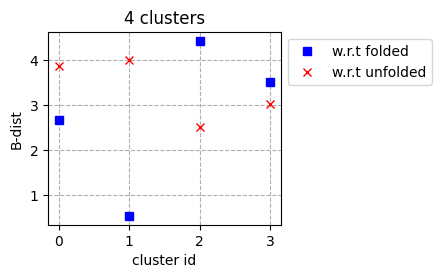

In [15]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("4 clusters")
wsgmm4 = wsgmm_list[0]
for i in range(wsgmm4.n_clusters):
    x = plt.plot(i, dist_data[0][i,0], 's', color="b", label="w.r.t folded" if i == 0 else "")
    y = plt.plot(i, dist_data[0][i,1], 'x', color="r", label="w.r.t unfolded" if i == 0 else "")
plt.legend(bbox_to_anchor=[1,1])

### Plot the distances for 5 cluster case 

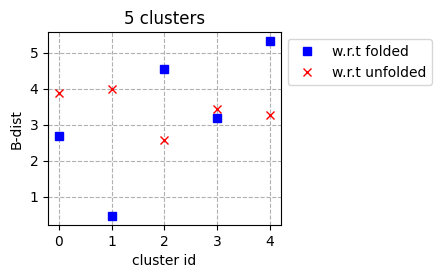

In [16]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("5 clusters")
wsgmm5 = wsgmm_list[1]
for i in range(wsgmm5.n_clusters):
    x = plt.plot(i, dist_data[1][i,0], 's', color="b", label="w.r.t folded" if i == 0 else "")
    y = plt.plot(i, dist_data[1][i,1], 'x', color="r", label="w.r.t unfolded" if i == 0 else "")
plt.legend(bbox_to_anchor=[1,1])

### Global Alignment of trajectory 

In [18]:
print(traj.shape, weights.shape)

(100001, 101, 3) (100001,)


In [55]:
# load traj 
global_aligned_traj = np.load("global_aligned_traj.npy", allow_pickle=True)
print(global_aligned_traj.shape)

(100001, 101, 3)


### We are going to choose 4 state shapeGMM fit object to get the new LD1 between

1. c=1 (closest to the folded) 
2. c=2 (closest to unfolded)

In [56]:
c1_indx = [x[0] for x in np.argwhere(wsgmm4.cluster_ids == 1)]  # close to folded 
c2_indx = [x[0] for x in np.argwhere(wsgmm4.cluster_ids == 2)]  # close to unfolded

print(len(c1_indx), len(c2_indx))

8426 32851


In [57]:
c1_traj = global_aligned_traj[c1_indx,:,:]   # close to folded (set labels 1)
c2_traj = global_aligned_traj[c2_indx,:,:]   # close to unfolded (set labels 0)

comb_traj = np.concatenate([c1_traj, c2_traj], axis=0)
labels = np.concatenate([np.ones(len(c1_indx)), np.zeros(len(c2_indx))], axis=0)

print(comb_traj.shape, labels.shape)

(41277, 101, 3) (41277,)


### perform weighted LDA calculation

In [58]:
print(global_aligned_traj.shape, weights.shape, wsgmm4.cluster_ids.shape)

(100001, 101, 3) (100001,) (100001,)


In [59]:
from WeightedLDA import WeightedLDA as WL

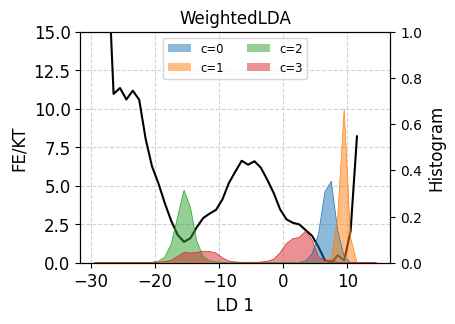

In [60]:
ld_range = (-30,15)
nbins = 45

fig, ax = plt.subplots(1, 1, figsize=(4,3)) 

ax.set_title("WeightedLDA", fontsize=12)
#ax.set_ylabel("FE (kcal/mol)",fontsize=12)
ax.set_ylabel("FE/KT", fontsize=12)
ax.set_xlabel("LD 1", fontsize=12)
ax.tick_params(axis='both',labelsize=12)

# lda calculation
lda = WL.WeightedLDA()

# get the weights
sel_weights = np.concatenate([weights[c1_indx], weights[c2_indx]], axis=0)

lda.fit(comb_traj.reshape(comb_traj.shape[0], comb_traj.shape[1]*3), labels, wgts=sel_weights)
ld1_all = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], global_aligned_traj.shape[1]*3))[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1_all, range=ld_range, bins=nbins, density=True, weights=weights)
#fe = -kt*np.log(hist)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
ax.plot(grids, fe-fe.min(), lw=1.5, color="k", ls="-")
ax.grid(axis='both', which='major', linestyle='--', color='lightgrey')
ax.set_ylim(0,15.0)

ax_inv = ax.twinx()
ax_inv.set_ylim(0,1.0)
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(wsgmm4.n_clusters):
    indices = [x[0] for x in np.argwhere(wsgmm4.cluster_ids == i)]
    H, _ = np.histogram(ld1_all[indices], range=ld_range, bins=nbins, density=True, weights=weights[indices])

    ax_inv.fill_between(grids, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(grids, H, lw=0.5)
    
ax_inv.legend(ncol=2, loc="upper center", fontsize="small")

In [61]:
print(kt)
print(min(ld1_all), max(ld1_all))

0.715393
-28.015479273067992 11.155760799598527


In [62]:
# save the lda coefficients
np.savetxt("ld1_4states_scalings.txt", lda.scalings_[:,0])

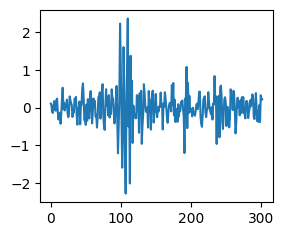

In [63]:
plt.figure(figsize=(3,2.5))
#plt.grid()
plt.plot(lda.scalings_[:,0], '-')

In [64]:
# calculating the standard deviation
print(np.std(ld1_all[c1_indx]))
print(np.std(ld1_all[c1_indx])/2)
print(np.std(ld1_all[c1_indx])/3)

0.7098992946086943
0.35494964730434714
0.2366330982028981


In [65]:
print(ld1_all.shape)

(100001,)
